In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from psiam_tied_dv_map_utils import rho_A_t_fn, up_RTs_fit_fn, down_RTs_fit_fn, up_RTs_fit_single_t_fn, psiam_tied_data_gen_wrapper, psiam_tied_data_gen_wrapper_V2
import sys
import multiprocessing
from psiam_tied_no_dv_map_utils import cum_A_t_fn, all_RTs_fit_OPTIM_fn
from psiam_tied_no_dv_map_utils import rho_A_t_fn, cum_A_t_fn, rho_E_minus_small_t_NORM_fn
from psiam_tied_dv_map_utils import cum_E_t_fn
from tqdm import tqdm
from scipy.integrate import trapezoid
import random
from diagnostics_class import Diagnostics

In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

df = df[  df['LED_trial'] == 0 ]

# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))

# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)


ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [3]:
import pickle
with open('../fitting_aborts/post_led_censor_test_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

vp_sample = vp.sample(int(1e6))[0]

V_A = np.mean(vp_sample[:,0])
theta_A = np.mean(vp_sample[:,1])
t_motor = 0.04
t_A_aff = np.mean(vp_sample[:,2]) - t_motor

In [4]:
with open('COND_choice_all_trials.pkl', 'rb') as f:
    vp = pickle.load(f)

vp = vp.vp

vp_samples = vp.sample(int(1e5))[0]
vp_samples[:,1] = vp_samples[:,1] * 1e3

lambda_mean = np.mean(vp_samples[:,0])
T0_mean = np.mean(vp_samples[:,1]) / 1e3
theta_E_mean = np.mean(vp_samples[:,2])

t_E_aff_mean = np.mean(vp_samples[:,3])
Z_E_mean = np.mean(vp_samples[:,4])
L_mean = np.mean(vp_samples[:,5])

# T0 testing

In [ ]:
N_print = 50_000 + 1
dt = 1e-3
N_sim = int(50e3)

t_stim_sampled = np.random.choice(df['intended_fix'], N_sim)

T0_arr = np.linspace(0.2, 0.9, 5)
T0_arr = T0_arr * 1e-3
ABL_arr = [40]


for T0_mean in T0_arr:
    sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_V2)(V_A, theta_A, ABL_arr, ILD_arr, lambda_mean, T0_mean, theta_E_mean, Z_E_mean, t_A_aff, t_E_aff_mean, t_motor, L_mean, \
                                                                         t_stim_sampled[iter_num], iter_num, N_print, dt) for iter_num in range(N_sim)) 

    sim_results_valid = [res for res in sim_results if res['rt'] > res['t_stim']]
    sim_results_valid_obj = Diagnostics(pd.DataFrame(sim_results_valid))
    pscyho = sim_results_valid_obj.plot_psycho()
    all_ILD = np.sort(df['ILD'].unique())
    plt.plot(all_ILD, pscyho[40], label=f'T0={T0_mean*1000:.2f}ms')
    plt.legend()



# t_E_aff testing

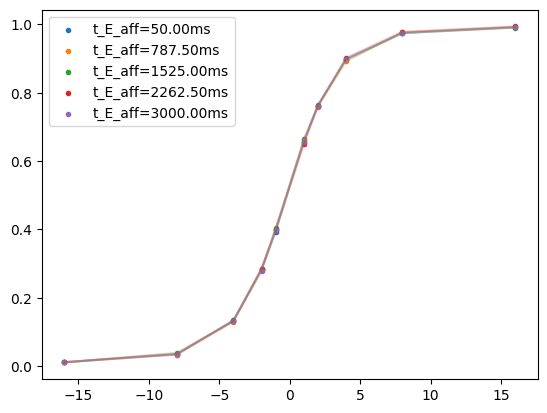

In [32]:
N_print = 50_000 + 1
dt = 1e-3
N_sim = int(100e3)

t_stim_sampled = np.random.choice(df['intended_fix'], N_sim)

t_E_aff_arr = np.linspace(0.05, 3, 5)
ABL_arr = [40]

for t_E_aff in t_E_aff_arr:
    sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_V2)(V_A, theta_A, ABL_arr, ILD_arr, lambda_mean, T0_mean, theta_E_mean, Z_E_mean, t_A_aff, t_E_aff, t_motor, L_mean, \
                                                                         t_stim_sampled[iter_num], iter_num, N_print, dt) for iter_num in range(N_sim)) 

    sim_results_valid = [res for res in sim_results if res['rt'] > res['t_stim']]
    sim_results_valid_obj = Diagnostics(pd.DataFrame(sim_results_valid))
    pscyho = sim_results_valid_obj.plot_psycho()
    all_ILD = np.sort(df['ILD'].unique())
    plt.plot(all_ILD, pscyho[40], alpha=0.3)
    plt.scatter(all_ILD, pscyho[40], label=f't_E_aff={t_E_aff*1000:.2f}ms', marker='.')

    plt.legend()



# t_A_aff?

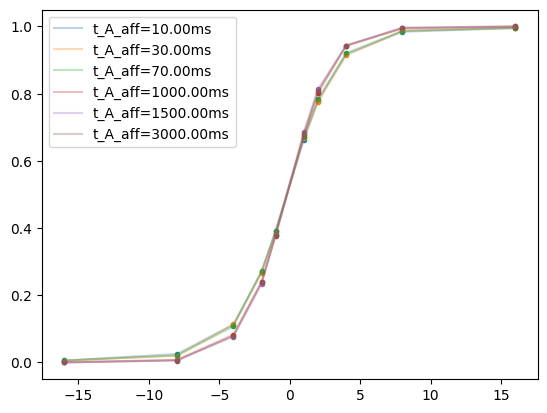

In [26]:
N_print = 50_000 + 1
dt = 1e-3
N_sim = int(100e3)

t_stim_sampled = np.random.choice(df['intended_fix'], N_sim)

# t_A_aff = np.linspace(0.01, 0.09, 5)
t_A_aff_arr = [0.01, 0.03, 0.07, 1, 1.5, 3]
ABL_arr = [40]

for t_A_aff in t_A_aff_arr:
    sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_V2)(V_A, theta_A, ABL_arr, ILD_arr, lambda_mean, T0_mean, theta_E_mean, Z_E_mean, t_A_aff, t_E_aff_mean, t_motor, L_mean, \
                                                                         t_stim_sampled[iter_num], iter_num, N_print, dt) for iter_num in range(N_sim)) 

    sim_results_valid = [res for res in sim_results if res['rt'] > res['t_stim']]
    sim_results_valid_obj = Diagnostics(pd.DataFrame(sim_results_valid))
    pscyho = sim_results_valid_obj.plot_psycho()
    all_ILD = np.sort(df['ILD'].unique())
    plt.plot(all_ILD, pscyho[40], label=f't_A_aff={t_A_aff*1000:.2f}ms', alpha=0.3)
    plt.scatter(all_ILD, pscyho[40], marker='.')

    plt.legend()



# t motor?

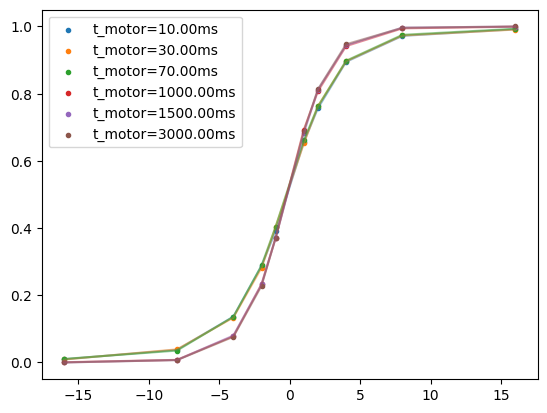

In [23]:
N_print = 50_000 + 1
dt = 1e-3
N_sim = int(100e3)

t_stim_sampled = np.random.choice(df['intended_fix'], N_sim)

t_motor_arr = [0.01, 0.03, 0.07, 1, 1.5, 3]
ABL_arr = [40]

for t_motor in t_motor_arr:
    sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_V2)(V_A, theta_A, ABL_arr, ILD_arr, lambda_mean, T0_mean, theta_E_mean, Z_E_mean, t_A_aff, t_E_aff_mean, t_motor, L_mean, \
                                                                         t_stim_sampled[iter_num], iter_num, N_print, dt) for iter_num in range(N_sim)) 

    sim_results_valid = [res for res in sim_results if res['rt'] > res['t_stim']]
    sim_results_valid_obj = Diagnostics(pd.DataFrame(sim_results_valid))
    pscyho = sim_results_valid_obj.plot_psycho()
    all_ILD = np.sort(df['ILD'].unique())
    plt.scatter(all_ILD, pscyho[40], label=f't_motor={t_motor*1000:.2f}ms', marker='.')
    plt.plot(all_ILD, pscyho[40], alpha=0.5)

    plt.legend()


In [5]:
from psiam_tied_no_dv_map_utils import CDF_E_minus_small_t_NORM_fn_vectorized, rho_A_t_fn_vectorized,P_small_t_btn_x1_x2_vectorized
import time
from scipy.interpolate import interp1d

In [6]:
x1 = 1; x2 = 2
def unknownn(t, V_A, theta_A, x1, x2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max, t_A_aff, t_motor, t_stim):
    return rho_A_t_fn_vectorized(t - t_A_aff - t_motor, V_A, theta_A) * ( CDF_E_minus_small_t_NORM_fn_vectorized(t - t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max) + \
                                                 P_small_t_btn_x1_x2_vectorized(x1, x2, t - t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max) )

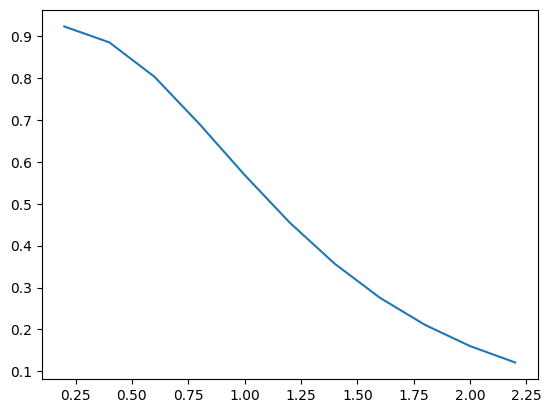

In [36]:
ABL = 40
t_stim_arr = np.arange(0.2, 2.3, 0.2)
unknown_vs_ILD_dict = {}
for ILD in ILD_arr:
    unknown_vs_ILD_dict[ILD] = np.zeros_like(t_stim_arr)
    for stim_idx, t_stim in enumerate(t_stim_arr):
        t_pts = np.arange(0, 10, 0.001)
        y = unknownn(t_pts, V_A, theta_A, x1, x2, ABL, ILD, lambda_mean, T0_mean, theta_E_mean, Z_E_mean, 1, 10, t_A_aff, t_motor, t_stim)
        unknown_vs_ILD_dict[ILD][stim_idx] = trapezoid(y, t_pts)


plt.plot(t_stim_arr, unknown_vs_ILD_dict[4], label='ABL=40')

In [46]:
class Diagnostics:
    """
    Remove truncated aborts by urself

    data frame with column names
    rt: RT wrt fixation
    t_stim: stimulus onset
    choice: 1 or -1
    ABL, ILD
    correct: 1 or 0
    """
    def __init__(self, data):
        self.data = data

    def plot_rtd_wrt_fix(self,bins):
        """
        return x and y for plotting
        """
        df = self.data.copy()
        rt_wrt_fix = df['rt']
        rt_wrt_fix_hist, _ = np.histogram(rt_wrt_fix, bins=bins, density=True)
        
        bin_centers = bins[:-1] + 0.5*(bins[1] - bins[0])

        return bin_centers, rt_wrt_fix_hist
    

    def plot_rtd_wrt_stim(self,bins):
        df = self.data.copy()
        rt_wrt_stim = df['rt'] - df['t_stim']
        rt_wrt_stim_hist, _ = np.histogram(rt_wrt_stim, bins=bins, density=True)
        
        bin_centers = bins[:-1] + 0.5*(bins[1] - bins[0])

        return bin_centers, rt_wrt_stim_hist

    def plot_tacho(self, bins):
        # prob of correct vs RT
        df = self.data.copy()
        df['RT_bin'] = pd.cut(df['rt'] - df['t_stim'], bins=bins, include_lowest=True)
        grouped_by_rt_bin = df.groupby('RT_bin', observed=False)['correct'].agg(['mean', 'count'])
        grouped_by_rt_bin['bin_mid'] = grouped_by_rt_bin.index.map(lambda x: x.mid)
        return grouped_by_rt_bin['bin_mid'], grouped_by_rt_bin['mean']
    
    def plot_chrono(self):
        # mean rt vs abs ILD for each ABL
        df = self.data.copy()
        all_ABL = np.sort(df['ABL'].unique())
        all_ILD = np.sort(df['ILD'].unique())
        all_ILD = all_ILD[all_ILD > 0] 

        abl_rt_dict = {}

        for ABL in all_ABL:
            per_ILD_rt = np.zeros_like(all_ILD)
            for idx, ILD in enumerate(all_ILD):
                filtered_df = df[ (df['ABL'] == ABL) \
                                            & (df['ILD'].isin([ILD, -ILD])) ]
                mean_rt = (filtered_df['rt'] - filtered_df['t_stim']).replace([np.nan, np.inf, -np.inf], np.nan).dropna().mean()
                per_ILD_rt[idx] = mean_rt
            abl_rt_dict[ABL] = per_ILD_rt
        
        return all_ILD, abl_rt_dict

    def plot_quantile(self):
        # 10 - 90 percentiles in steps of 20
        df = self.data.copy()
        df['rt_wrt_stim'] = df['rt'] - df['t_stim']

        abl_ild_quantiles = {}
        quantile_levels = [0.1, 0.3, 0.5, 0.7, 0.9]

        all_ABL = np.sort(df['ABL'].unique())
        all_ILD = np.sort(df['ILD'].unique())
        all_ILD = all_ILD[all_ILD > 0] 

        for abl in all_ABL:
            abl_ild_quantiles[abl] = {}
            for ild in all_ILD:
                filtered_df = df[(df['ABL'] == abl) & (df['ILD'].isin([ild, -ild]))]
                quantiles = filtered_df['rt_wrt_stim'].replace([np.nan, np.inf, -np.inf], np.nan).dropna().quantile(quantile_levels).tolist()
                abl_ild_quantiles[abl][ild] = quantiles

        return abl_ild_quantiles
    
    def plot_psycho(self):
        df = self.data.copy()
        prob_choice_dict = {}

        all_ABL = np.sort(df['ABL'].unique())
        all_ILD = np.sort(df['ILD'].unique())

        for abl in all_ABL:
            filtered_df = df[df['ABL'] == abl]
            prob_choice_dict[abl] = [sum(filtered_df[filtered_df['ILD'] == ild]['choice'] == -1) / len(filtered_df[filtered_df['ILD'] == ild]) for ild in all_ILD]

        return prob_choice_dict



In [47]:
t_stim = 0.345
N_sim = int(25e3)
dt = 1e-3
sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_V2)(V_A, theta_A, [40], ILD_arr, lambda_mean, T0_mean, theta_E_mean, Z_E_mean, t_A_aff, t_E_aff_mean, t_motor, L_mean, \
                                                                         t_stim, iter_num, N_sim + 1, dt) for iter_num in range(N_sim)) 

sim_results_valid = [res for res in sim_results if res['rt'] > res['t_stim']]
sim_results_valid_obj = Diagnostics(pd.DataFrame(sim_results_valid))
pscyho = sim_results_valid_obj.plot_psycho()
all_ILD = np.sort(df['ILD'].unique())

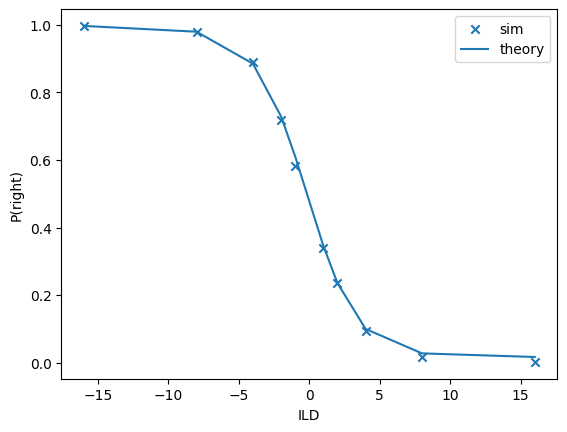

Text(0, 0.5, 'P(right) - theory')

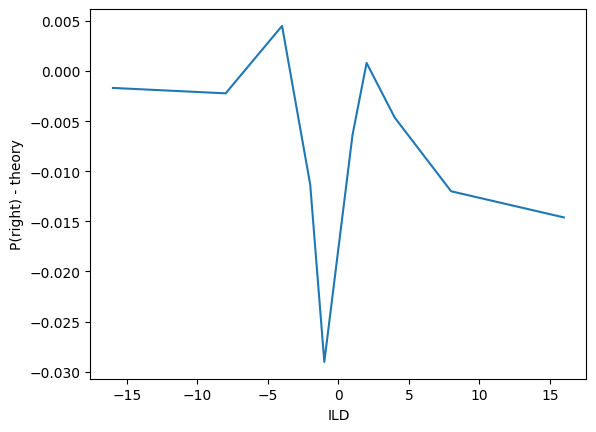

In [48]:
psycho_theory = np.zeros_like(ILD_arr)
for i, ILD in enumerate(ILD_arr):
    prob_of_hit_all_t_stim = unknown_vs_ILD_dict[ILD]
    # Create the cubic interpolation function
    cubic_interp_func = interp1d(
        t_stim_arr, 
        prob_of_hit_all_t_stim, 
        kind='cubic', 
        fill_value="extrapolate",  # Allows extrapolation outside the data range
        assume_sorted=True         # Assumes input data is sorted
    )

    psycho_theory[i] = 1 - cubic_interp_func(t_stim)


plt.scatter(all_ILD, pscyho[40], marker='x', label='sim')
plt.plot(all_ILD, psycho_theory, label='theory')
plt.legend()
plt.xlabel('ILD')
plt.ylabel('P(right)')

plt.show()
plt.plot(all_ILD, pscyho[40] - psycho_theory)
plt.xlabel('ILD')
plt.ylabel('P(right) - theory')

# up + down

In [58]:
x1 = 1; x2 = 2
def unknownn_neg(t, V_A, theta_A, x1, x2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max, t_A_aff, t_motor, t_stim):
    return rho_A_t_fn_vectorized(t - t_A_aff - t_motor, V_A, theta_A) * ( CDF_E_minus_small_t_NORM_fn_vectorized(t - t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, -1, K_max) + \
                                                 P_small_t_btn_x1_x2_vectorized(0, 1, t - t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max) )

In [59]:
t_stim = 0.3

t_pts = np.arange(0, 10, 0.001)
p_up_psy = np.zeros_like(ILD_arr)
p_down_psy = np.zeros_like(ILD_arr)

for i, ILD in enumerate(ILD_arr):
    y = unknownn(t_pts, V_A, theta_A, x1, x2, ABL, ILD, lambda_mean, T0_mean, theta_E_mean, Z_E_mean, 1, 10, t_A_aff, t_motor, t_stim)
    p_up_psy[i] = trapezoid(y, t_pts)

    y = unknownn_neg(t_pts, V_A, theta_A, x1, x2, ABL, ILD, lambda_mean, T0_mean, theta_E_mean, Z_E_mean, 1, 10, t_A_aff, t_motor, t_stim)
    p_down_psy[i] = trapezoid(y, t_pts)

array([0.99059266, 0.99059266, 0.99059267, 0.99059267, 0.99059267,
       0.99059267, 0.99059267, 0.99059267, 0.99059266, 0.99059266])

[0.99059266 0.99059266 0.99059267 0.99059267 0.99059267 0.99059267
 0.99059267 0.99059267 0.99059266 0.99059266]


(0.0, 1.1)

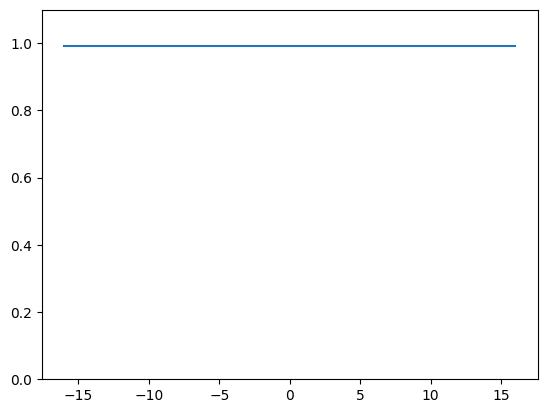

In [71]:
q = p_up_psy + p_down_psy
print(q)
plt.plot(ILD_arr, q)
plt.ylim(0, 1.1)